In [457]:
import torch 
import numpy as np

import os
import pandas as pd
import geopandas as gpd
import pickle as pickle

# from loc_predict.processing import _split_train_test

from shapely import wkt

import scipy.stats as stats
from joblib import Parallel, delayed
import multiprocessing

from tqdm import tqdm


import powerlaw
import matplotlib.pyplot as plt
from scipy.spatial import distance

# from metrics.metrics import radius_gyration, jump_length, location_frquency, wait_time
from utils.utils import load_data

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [288]:
data_dir = os.path.join("data", "validation")

def save_pk_file(save_path, data):
    """Function to save data to pickle format given data and path."""
    with open(save_path, "wb") as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [458]:
def _apply_parallel(ls, func, n=-1):
    """parallel apply for spending up."""
    length = len(ls)
    cpunum = multiprocessing.cpu_count()
    if length < cpunum:
        spnum = length
    if n < 0:
        spnum = cpunum + n + 1
    else:
        spnum = n or 1

    return Parallel(n_jobs=n, verbose=0)(delayed(func)(seq) for seq in ls)

# Validation


In [ ]:
simulated_sp = pd.read_csv(os.path.join(data_dir, "mobis_mhsa_generation.csv"))
simulated_sp

In [ ]:
simulated_sp = simulated_sp.merge(
    loc.reset_index()[["id", "center"]].rename(columns={"id": "location_id"}), how="left", left_on="generated_ls", right_on="location_id"
)

In [ ]:
simulated_sp.rename(columns={"center": "geometry"}, inplace=True)
simulated_sp["geometry"] = simulated_sp["geometry"].apply(wkt.loads)
simulated_sp = gpd.GeoDataFrame(simulated_sp, geometry="geometry", crs="EPSG:4326")

In [ ]:
simulated_sp.drop(columns={"user_id", "generated_ls"}, inplace=True)
simulated_sp.rename(columns={"seq_id": "user_id"}, inplace=True)

# Validate metric calculation

In [4]:
from metrics.evaluations import Metric
from utils.utils import load_data, setup_seed, load_config
from easydict import EasyDict as edict
# from utils.dataloader import get_train_test, _get_valid_sequence

import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely import wkt

In [52]:
# initialization
config = load_config("./config/movesim.yml")
config = edict(config)

# read and preprocess
sp = pd.read_csv(os.path.join(config.temp_save_root, "sp.csv"), index_col="id")
loc = pd.read_csv(os.path.join(config.temp_save_root, "locs_s2.csv"), index_col="id")
sp = load_data(sp, loc)

all_locs = pd.read_csv(os.path.join(config.temp_save_root, "all_locations.csv"), index_col="id")
all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
# transform to projected coordinate systems
all_locs = all_locs.to_crs("EPSG:2056")

train_data, vali_data, test_data, all_locs = get_train_test(sp, all_locs=all_locs)

config["total_loc_num"] = int(all_locs.loc_id.max() + 1)
config["total_user_num"] = int(train_data.user_id.max() + 1)

In [53]:
train_data["id"] = np.arange(len(train_data))
vali_data["id"] = np.arange(len(vali_data))
test_data["id"] = np.arange(len(test_data))

train_idx = _get_valid_sequence(train_data, print_progress=config.verbose, previous_day=config.previous_day)
vali_idx = _get_valid_sequence(vali_data, print_progress=config.verbose, previous_day=config.previous_day)
test_idx = _get_valid_sequence(test_data, print_progress=config.verbose, previous_day=config.previous_day)


100%|██████████| 2094/2094 [00:10<00:00, 199.15it/s]


In [5]:
temp_data = train_data.copy()
temp_data.set_index("id", inplace=True)

train_seq = [temp_data.iloc[idx[0] : idx[1]]["location_id"].values for idx in train_idx]

In [6]:
temp_data = test_data.copy()
temp_data.set_index("id", inplace=True)

test_seq = [temp_data.iloc[idx[0] : idx[1]]["location_id"].values for idx in test_idx]

In [7]:
metrics = Metric(config, locations=all_locs, input_data=vali_data, valid_start_end_idx=vali_idx)

In [8]:
jsds = metrics.get_individual_jsds(gene_data=test_seq)
print(
    "Metric: distance {:.3f}, rg {:.3f}, period {:.3f}, topk all {:.3f}, topk {:.3f}".format(
        jsds[0], jsds[1], jsds[2], jsds[3], jsds[4]
    )
)

Metric: distance 0.091, rg 0.081, period 0.024, topk all 0.005, topk 0.000


In [9]:
jsds = metrics.get_individual_jsds(gene_data=train_seq)
print(
    "Metric: distance {:.3f}, rg {:.3f}, period {:.3f}, topk all {:.3f}, topk {:.3f}".format(
        jsds[0], jsds[1], jsds[2], jsds[3], jsds[4]
    )
)

Metric: distance 0.092, rg 0.071, period 0.021, topk all 0.000, topk 0.288


## Diffusion sequence

In [289]:
from sklearn.preprocessing import OrdinalEncoder
from metrics.evaluations import Metric

In [290]:
# initialization
config = load_config("./config/diff.yml")
config = edict(config)

In [291]:
path = f"{config.data_dir}/test_level{config.level}_{config.src_min_days}_{config.tgt_min_days}_tiny.pk"
sequence_ls = pickle.load(open(path, "rb"))

tgt_tiny = []
src_tiny = []
for record in sequence_ls:
    tgt_tiny.append(record["tgt"])
    src_tiny.append(record["src"])

FileNotFoundError: [Errno 2] No such file or directory: '/cluster/scratch/hongy/generation/data/diff/test_level10_13_14_7_tiny.pk'

In [7]:
path = f"{config.data_dir}/train_level{config.level}_{config.src_min_days}_{config.tgt_min_days}_tiny.pk"
sequence_ls = pickle.load(open(path, "rb"))

train_tiny = []
for record in sequence_ls:
    train_tiny.append(record["tgt"])

In [8]:
all_locs = pd.read_csv(os.path.join("data", "s2_loc_visited_level10_13.csv"), index_col="id")
all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
# transform to projected coordinate systems
all_locs = all_locs.to_crs("EPSG:2056")

In [9]:
enc = OrdinalEncoder(dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1).fit(
    all_locs["loc_id"].values.reshape(-1, 1)
)
all_locs["loc_id"] = enc.transform(all_locs["loc_id"].values.reshape(-1, 1)) + 2

In [10]:
all_locs

,loc_id,level,geometry,freq,area
id,,,,,
0,2,10,POINT (2824875.045 1159436.528),1,POLYGON ((10.405097146225662 46.50637570678295...
1,3,13,POINT (2822437.857 1167754.527),38,POLYGON ((10.347820052132302 46.61871685680636...
2,4,13,POINT (2815796.126 1167304.569),1,POLYGON ((10.260953592346382 46.61685460820135...
3,5,13,POINT (2816020.303 1168362.492),1,POLYGON ((10.264376293749178 46.62629143145975...
4,6,13,POINT (2818994.419 1169160.037),1,POLYGON ((10.303565033130825 46.63249007077394...
...,...,...,...,...,...
14876,14878,13,POINT (2767507.842 1213073.682),1,"POLYGON ((9.64763962539829 47.042237657717536,..."
14877,14879,13,POINT (2768419.907 1212986.551),1,"POLYGON ((9.65960383635977 47.04122268391671, ..."
14878,14880,13,POINT (2769332.126 1212899.406),1,"POLYGON ((9.671569607102107 47.04020629289218,..."


In [11]:
metrics = Metric(max_locs=config.max_location, locations=all_locs, reference_data=train_tiny)

In [12]:
jsds = metrics.get_individual_jsds(gene_data=tgt_tiny)
print(
    "Metric: distance {:.3f}, rg {:.3f}, period {:.3f}, topk all {:.3f}, topk {:.3f}".format(
        jsds[0], jsds[1], jsds[2], jsds[3], jsds[4]
    )
)

Metric: distance 0.252, rg 0.237, period 0.227, topk all 0.023, topk 0.790


In [13]:
jsds = metrics.get_individual_jsds(gene_data=src_tiny)
print(
    "Metric: distance {:.3f}, rg {:.3f}, period {:.3f}, topk all {:.3f}, topk {:.3f}".format(
        jsds[0], jsds[1], jsds[2], jsds[3], jsds[4]
    )
)

Metric: distance 0.246, rg 0.283, period 0.333, topk all 0.027, topk 0.833


In [14]:
metrics = Metric(max_locs=config.max_location, locations=all_locs, reference_data=src_tiny)

In [15]:
jsds = metrics.get_individual_jsds(gene_data=tgt_tiny)
print(
    "Metric: distance {:.3f}, rg {:.3f}, period {:.3f}, topk all {:.3f}, topk {:.3f}".format(
        jsds[0], jsds[1], jsds[2], jsds[3], jsds[4]
    )
)

Metric: distance 0.069, rg 0.294, period 0.300, topk all 0.018, topk 0.745


In [420]:
import json

def read_seq(file_name):

    predict_ls = []
    true_ls = []
    src_ls = []
    with open(file_name, "r") as f_reader:
        for row in f_reader:
            content = json.loads(row)

            src_ls.append((np.array(content["source"])[:-1]))

            reference_arr = np.array(content["reference"])
            try:
                reference_arr = reference_arr[:np.where(reference_arr == 0)[0][0]]
            except IndexError:
                reference_arr = reference_arr
            true_ls.append(reference_arr)

            if len(content["recover"]) >= 50:
                predict_ls.append(np.array(content["recover"][:50]).squeeze())
            else:
                print(len(content["recover"]))
    return predict_ls, true_ls, src_ls

# file_name = ".\\runs\mobis_diffseq_evaluate_v2_b\seed101_solverstep10.json"
file_name = ".\\data\\validation\\seed101_solverstep20_ema21_small.json"

predict_ls, true_ls, src_ls = read_seq(file_name)
        

## Jump length

In [424]:
def get_jumplength(ls, geo_x, geo_y):
    dist = []
    for seq in ls:
        locs = seq - 2 # padding and seperator

        dist.extend([np.sqrt((geo_x[locs][i] - geo_x[locs][i - 1])**2 + (geo_y[locs][i] - geo_y[locs][i - 1])**2) for i in range(1, len(locs))])
    dist = np.array(dist)

    return dist

In [425]:
geo_x = all_locs["geometry"].x.values
geo_y = all_locs["geometry"].y.values

predict_jp = get_jumplength(predict_ls, geo_x, geo_y)
true_jp = get_jumplength(true_ls, geo_x, geo_y)
source_jp = get_jumplength(src_ls, geo_x, geo_y)

predict_jp = predict_jp[predict_jp>1]
true_jp = true_jp[true_jp>1]
source_jp = source_jp[source_jp>1]

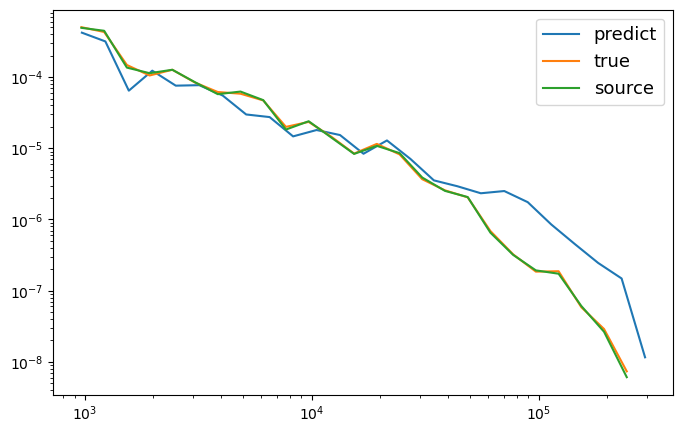

In [426]:
plt.figure(figsize=(8, 5))


# fit power law
fit = powerlaw.Fit(true_jp, xmin=1)

# plotting
powerlaw.plot_pdf(predict_jp, label="predict")
powerlaw.plot_pdf(true_jp, label="true")
powerlaw.plot_pdf(source_jp, label="source")


# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
# fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

plt.legend(prop={"size": 13})
plt.show()

In [427]:
# predict = np.log(predict_jp)
# true = np.log(true_jp)
# source = np.log(source_jp)

predict = predict_jp
true = true_jp
source = source_jp

In [428]:
min = predict.min()
max = predict.max()
pred_dist_p, _ = np.histogram(predict, bins=1000, range=(min, max))
true_dist_p, _ =  np.histogram(true, bins=1000, range=(min, max))
source_dist_p, _ =  np.histogram(source, bins=1000, range=(min, max))

distance.jensenshannon(pred_dist_p, true_dist_p), distance.jensenshannon(source_dist_p, true_dist_p)

(0.25792141502638416, 0.04757367891556913)

## Visit frequency

In [429]:
def get_loc_p(ls):
    visits = np.zeros(shape=(len(all_locs)), dtype=float)
    for seq in ls:
        locs = seq - 2 # padding and seperator

        visits[locs] += 1
    visits.sort()
    visits = visits[::-1]
    return visits

In [430]:
predict_p = get_loc_p(predict_ls)
true_p = get_loc_p(true_ls)
source_p = get_loc_p(src_ls)


In [431]:
predict_p, true_p, source_p

(array([7748., 4426., 4227., ...,    0.,    0.,    0.]),
 array([4654., 3428., 2270., ...,    0.,    0.,    0.]),
 array([6521., 4924., 2784., ...,    0.,    0.,    0.]))

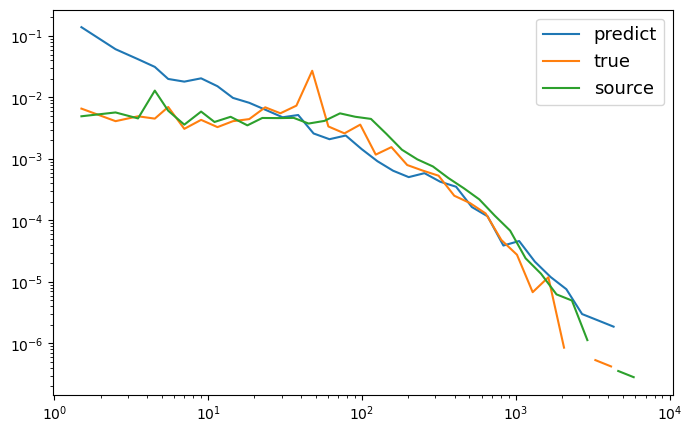

In [432]:
plt.figure(figsize=(8, 5))

predict = predict_p[predict_p>0]
true = true_p[true_p>0]
source = source_p[source_p>0]
# plotting
powerlaw.plot_pdf(predict, label="predict")
powerlaw.plot_pdf(true, label="true")
powerlaw.plot_pdf(source, label="source")


plt.legend(prop={"size": 13})
plt.show()

In [433]:
# predict = np.log(predict_p[:100])
# true = np.log(true_p[:100])
# source = np.log(source_p[:100])

predict = predict_p
true = true_p
source = source_p

In [434]:
distance.jensenshannon(predict, true), distance.jensenshannon(source, true)

(0.37708430966840895, 0.061078784201171306)

## Rg

In [435]:
def get_rg(ls, geo_x, geo_y):
    rgs = []

    for seq in ls:
        locs = seq - 2 # padding and seperator

        xs = np.take(geo_x, locs)
        ys = np.take(geo_y, locs)

        x_center = np.average(xs)
        y_center = np.average(ys)

        square_rg = np.average((xs - x_center) ** 2 + (ys - y_center) ** 2)

        rgs.append(np.sqrt(square_rg))
    return np.array(rgs, dtype=float)

In [436]:
geo_x = all_locs["geometry"].x.values
geo_y = all_locs["geometry"].y.values

predict_rg = get_rg(predict_ls, geo_x, geo_y)
true_rg = get_rg(true_ls, geo_x, geo_y)
source_rg = get_rg(src_ls, geo_x, geo_y)

predict_rg = predict_rg[predict_rg>1]
true_rg = true_rg[true_rg>1]
source_rg = source_rg[source_rg>1]

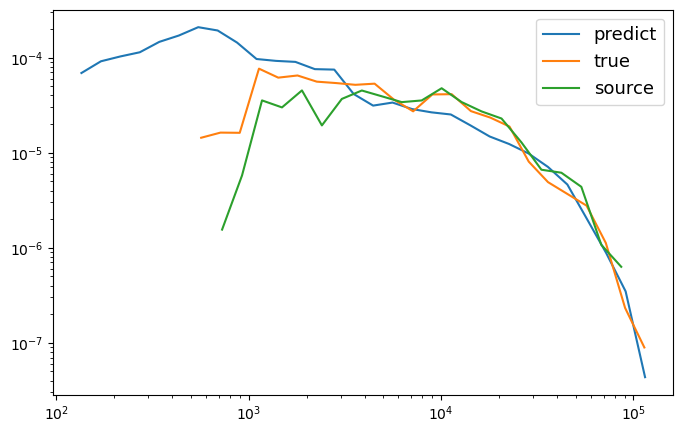

In [437]:
plt.figure(figsize=(8, 5))

# fit power law
fit = powerlaw.Fit(true_rg, xmin=1)

# plotting
powerlaw.plot_pdf(predict_rg, label="predict")
powerlaw.plot_pdf(true_rg, label="true")
powerlaw.plot_pdf(source_rg, label="source")


# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
# fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

plt.legend(prop={"size": 13})
plt.show()

In [438]:
predict = np.log(predict_rg)
true = np.log(true_rg)
source = np.log(source_rg)

# predict = predict_rg
# true = true_rg
# source = source_rg

In [439]:
min = predict.min()
max = predict.max()
pred_rg_p, _ = np.histogram(predict, bins=1000, range=(min, max))
true_rg_p, _ =  np.histogram(true, bins=1000, range=(min, max))
source_rg_p, _ =  np.histogram(source, bins=1000, range=(min, max))

distance.jensenshannon(pred_rg_p, true_rg_p), distance.jensenshannon(source_rg_p, true_rg_p)

(0.27528937051923696, 0.19124777664677634)

## BLEU

In [440]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def bleu_score(recover, reference):
    return sentence_bleu(
        [reference],
        recover,
        smoothing_function=SmoothingFunction().method4,
    )

def get_scores(pred_ls, ref_ls):
    bleu_ls = []
    for pred, ref in zip(pred_ls, ref_ls):

        bleu_ls.append(bleu_score(pred, ref))
    return bleu_ls

predict_src_bleu = get_scores(predict_ls, src_ls)
true_src_bleu = get_scores(true_ls, src_ls)
predict_true_bleu = get_scores(predict_ls, true_ls)

In [442]:
# np.average(predict_src_bleu), np.average(true_src_bleu), np.average(predict_true_bleu)
np.average(predict_src_bleu), np.average(predict_true_bleu)

(0.05886792299220909, 0.07743779234432556)

## Entropy

In [459]:
def real_entropy_individual(locs_series):

    n = len(locs_series)

    # 1 to ensure to consider the first situation from where
    # locs_series[i:j] = [] and locs_series[i:j] = locs_series[0:1]
    sum_lambda = 1

    for i in range(1, n - 1):
        j = i + 1

        while True:
            # if the locs_series[i:j] is longer than locs_series[:i],
            # we can no longer find it locs_series[i:j] in locs_series[:i]
            if j - i > i:
                break

            # if locs_series[i:j] exist in locs_series[:i], we increase j by 1
            # sliding_window_view creates sublist of length len(locs_series[i:j]) from locs_series[:i]
            ls = np.lib.stride_tricks.sliding_window_view(locs_series[:i], j - i).tolist()
            if tuple(locs_series[i:j]) in list(map(tuple, ls)):
                # if the subsequence already exist, we increase the sequence by 1, and check again
                j += 1
            else:
                # we find the "shortest substring" that does not exist in locs_series[:i]
                break

        # length of the substring
        sum_lambda += j - i

    # the function S5 from the suppl. material
    return 1.0 / (sum_lambda * 1 / n) * np.log(n)

predict_re = _apply_parallel(predict_ls, real_entropy_individual, n=-1)
true_re = _apply_parallel(true_ls, real_entropy_individual, n=-1)
source_re = _apply_parallel(src_ls, real_entropy_individual, n=-1)


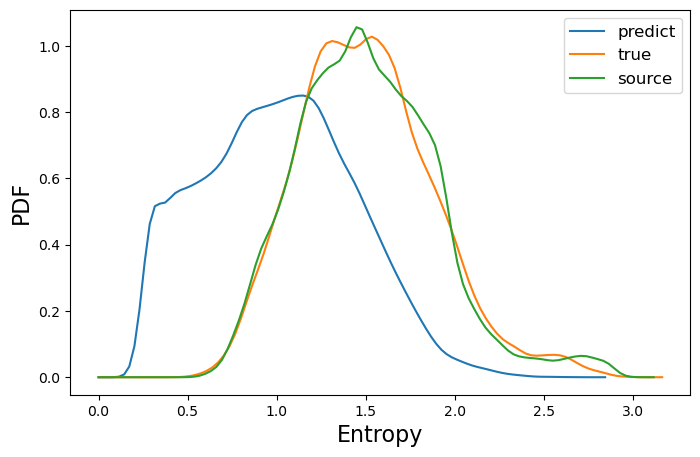

In [460]:


fig, ax = plt.subplots(1, 1, figsize=(8, 5))


density = stats.gaussian_kde(predict_re)
x = np.linspace(0, np.max(predict_re) + 0.2, 100)
ax.plot(x, density(x), label="predict")

density = stats.gaussian_kde(true_re)
x = np.linspace(0, np.max(true_re) + 0.2, 100)
ax.plot(x, density(x), label="true")

density = stats.gaussian_kde(source_re)
x = np.linspace(0, np.max(source_re) + 0.2, 100)
ax.plot(x, density(x), label="source")

plt.legend(prop={"size": 12})
plt.xlabel("Entropy", fontsize=16)
plt.ylabel("PDF", fontsize=16)

plt.show()


In [461]:
def uncorrelated_entropy_individual(locs_series):
    _, counts = np.unique(locs_series, return_counts=True)
    freq = counts/len(locs_series)
    return -(freq * np.log(freq)).sum()

predict_ue = [uncorrelated_entropy_individual(seq) for seq in predict_ls]
true_ue = [uncorrelated_entropy_individual(seq) for seq in true_ls]
source_ue = [uncorrelated_entropy_individual(seq) for seq in src_ls]

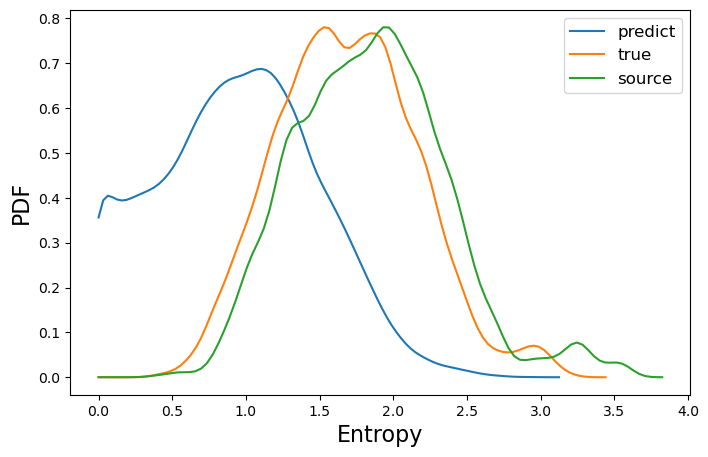

In [462]:

fig, ax = plt.subplots(1, 1, figsize=(8, 5))


density = stats.gaussian_kde(predict_ue)
x = np.linspace(0, np.max(predict_ue) + 0.2, 100)
ax.plot(x, density(x), label="predict")

density = stats.gaussian_kde(true_ue)
x = np.linspace(0, np.max(true_ue) + 0.2, 100)
ax.plot(x, density(x), label="true")

density = stats.gaussian_kde(source_ue)
x = np.linspace(0, np.max(source_ue) + 0.2, 100)
ax.plot(x, density(x), label="source")

plt.legend(prop={"size": 12})
plt.xlabel("Entropy", fontsize=16)
plt.ylabel("PDF", fontsize=16)

plt.show()


In [463]:
pred_diff = [re - ue for re, ue in zip(predict_re,predict_ue)]
true_diff = [re - ue for re, ue in zip(true_re,true_ue)]
source_diff = [re - ue for re, ue in zip(source_re,source_ue)]

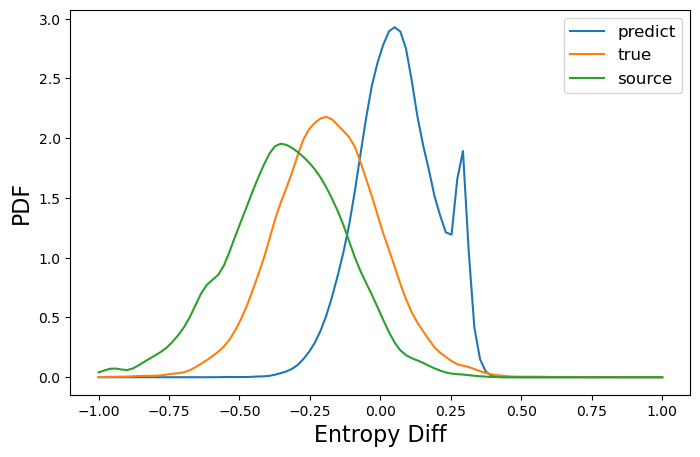

In [464]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))


density = stats.gaussian_kde(pred_diff)
x = np.linspace(-1, 1, 100)
ax.plot(x, density(x), label="predict")

density = stats.gaussian_kde(true_diff)
x = np.linspace(-1, 1, 100)
ax.plot(x, density(x), label="true")

density = stats.gaussian_kde(source_diff)
x = np.linspace(-1, 1, 100)
ax.plot(x, density(x), label="source")

plt.legend(prop={"size": 12})
plt.xlabel("Entropy Diff", fontsize=16)
plt.ylabel("PDF", fontsize=16)

plt.show()